# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

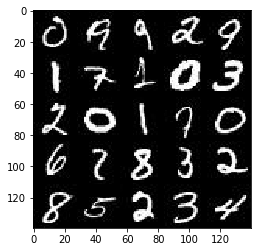

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

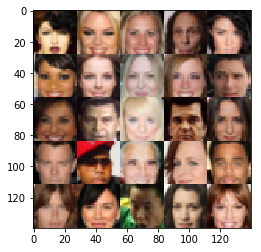

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Convolutional layer - Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)        
        # 4x4x256
        
        # Flatten it 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1) # Fully connected 
        out = tf.sigmoid(logits)        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
        # 28x28x3
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train, g_train
    """
    STUDENT NOTE: 
    
    When I try to implement this function as in the previous lessons:
    
    # Optimize 
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt 
    
    
    I get an error: 
    
    InvalidArgumentError: You must feed a value for placeholder tensor 'input_real' with dtype float 
        [[Node: input_real = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0]()]]
        
    
    I was stuck for a long time looking for the error so in forum I found the solution that currently is implementing 
    in this function. The reason for this solution is because, say in forum: 'In practice enclosing all graph update ops 
    as control dependencies may not be precise enough for that would include update ops in both the discriminator and 
    generator so with this way the generator's update ops and the discriminator's update ops are distinguished clearly.
    
    So I have a question, Why in the past notebooks the form of implementing (that is commented) worked well and here 
    not work?
    """
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2380... Generator Loss: 1.7954
Epoch 1/2... Discriminator Loss: 0.0792... Generator Loss: 3.0885
Epoch 1/2... Discriminator Loss: 0.0380... Generator Loss: 3.7922
Epoch 1/2... Discriminator Loss: 0.0332... Generator Loss: 3.7569
Epoch 1/2... Discriminator Loss: 0.0407... Generator Loss: 3.6470
Epoch 1/2... Discriminator Loss: 0.0230... Generator Loss: 4.1954
Epoch 1/2... Discriminator Loss: 0.0145... Generator Loss: 4.5819
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 4.7846
Epoch 1/2... Discriminator Loss: 0.0543... Generator Loss: 3.1937
Epoch 1/2... Discriminator Loss: 0.2694... Generator Loss: 2.0175


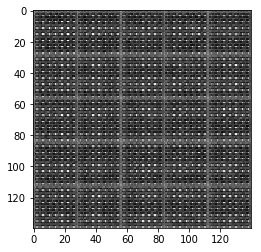

Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 4.2988
Epoch 1/2... Discriminator Loss: 0.0217... Generator Loss: 4.5319
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 4.7332
Epoch 1/2... Discriminator Loss: 0.0222... Generator Loss: 4.3698
Epoch 1/2... Discriminator Loss: 2.2081... Generator Loss: 0.1752
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 3.5706
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 2.3706... Generator Loss: 1.7764
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.4216
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.4291


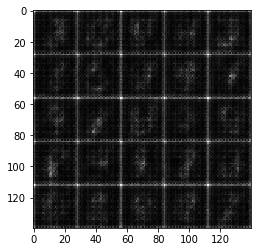

Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.6921
Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 1.1202
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.6257
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.0274
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.9655


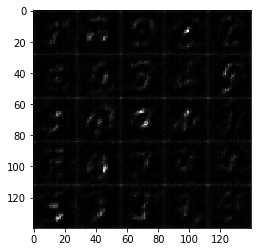

Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 1.5244
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.6673
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 1.5089


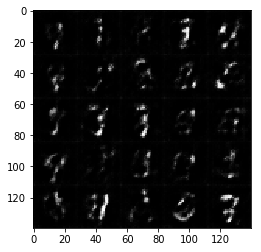

Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.2469
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 0.5554... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 1.2037
Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 1.2110


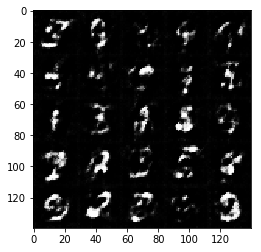

Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 1.3256
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 1.8425
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.9593
Epoch 1/2... Discriminator Loss: 0.6236... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 1.9680
Epoch 1/2... Discriminator Loss: 0.4185... Generator Loss: 1.5599
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.2541
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 1.8177
Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 1.1462


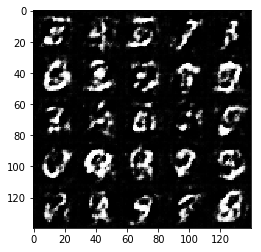

Epoch 1/2... Discriminator Loss: 0.5916... Generator Loss: 1.0913
Epoch 1/2... Discriminator Loss: 0.4279... Generator Loss: 1.7655
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 0.5587... Generator Loss: 2.2219
Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 2.0212
Epoch 1/2... Discriminator Loss: 0.4788... Generator Loss: 1.6710
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 0.2623... Generator Loss: 2.0494


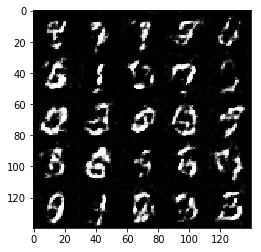

Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 0.5718... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 1.7557
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 1.5564
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 2.1102
Epoch 1/2... Discriminator Loss: 0.4345... Generator Loss: 1.7645
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 1.5581


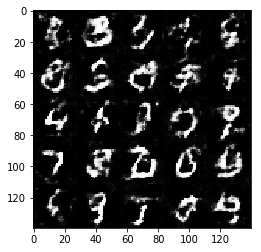

Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 1.4878
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 0.5513... Generator Loss: 1.4328
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 2.3731
Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 0.4309... Generator Loss: 2.1555
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 1.6097
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.4601


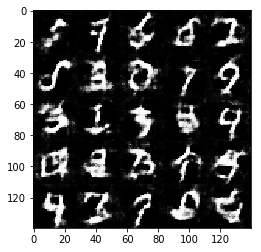

Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 2.3082
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.0648
Epoch 1/2... Discriminator Loss: 0.5457... Generator Loss: 1.4435
Epoch 1/2... Discriminator Loss: 0.5534... Generator Loss: 1.2530
Epoch 1/2... Discriminator Loss: 0.7187... Generator Loss: 1.4590
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.5376


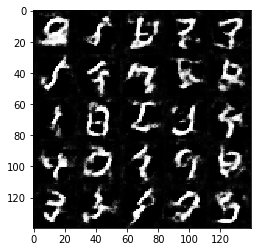

Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 2.3716
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.2678
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 1.7575
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 0.7459... Generator Loss: 1.6810
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 1.2725


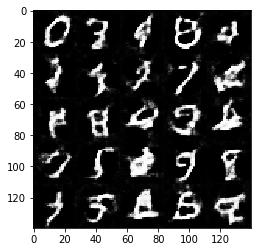

Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 2.0162
Epoch 1/2... Discriminator Loss: 0.4984... Generator Loss: 1.5669
Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.3298
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 0.6792
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 2.1744
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 0.9787


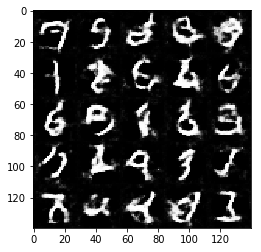

Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 1.1043
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 2.3753
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 1.2514
Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 0.6492... Generator Loss: 1.1149


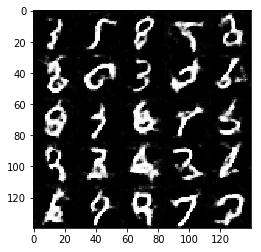

Epoch 1/2... Discriminator Loss: 0.6623... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 1.0616
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.0151
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.0174
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 2.5502
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 1.0232


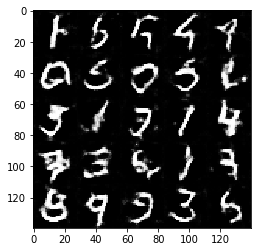

Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.5898
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 1.3380
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.7918


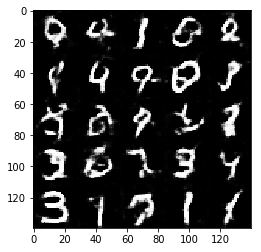

Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.7206... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 0.5661... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 0.6549


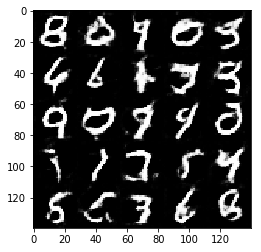

Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 0.6956... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 2.6350
Epoch 1/2... Discriminator Loss: 0.6590... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 0.4939... Generator Loss: 1.9345
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 0.9230


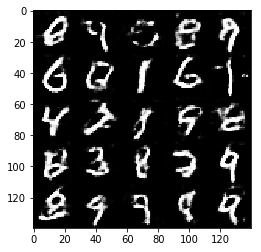

Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.5686
Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 1.6874
Epoch 1/2... Discriminator Loss: 0.5209... Generator Loss: 1.6430
Epoch 1/2... Discriminator Loss: 0.4894... Generator Loss: 1.4285
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 1.9994
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 0.7879... Generator Loss: 0.8049


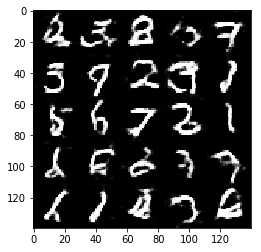

Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.8331
Epoch 1/2... Discriminator Loss: 0.8179... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.4225
Epoch 1/2... Discriminator Loss: 0.5215... Generator Loss: 1.2869
Epoch 1/2... Discriminator Loss: 0.5647... Generator Loss: 1.3025
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 1.6765
Epoch 1/2... Discriminator Loss: 0.5049... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.3648... Generator Loss: 1.8116
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 0.9295


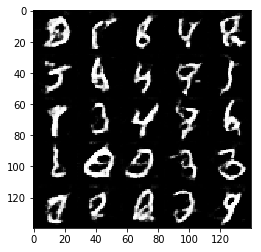

Epoch 2/2... Discriminator Loss: 0.5302... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 1.9109
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 2.4058
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 1.2496
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.1989


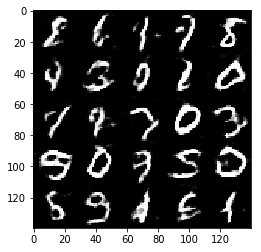

Epoch 2/2... Discriminator Loss: 0.5080... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 1.4830
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 0.9571
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 0.4356... Generator Loss: 2.0650


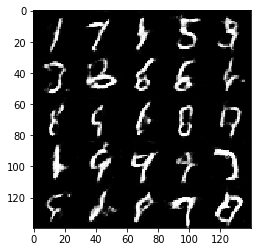

Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 1.4113
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 0.7318... Generator Loss: 0.8937
Epoch 2/2... Discriminator Loss: 0.4695... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 1.4755
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 2.8144
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 1.3343
Epoch 2/2... Discriminator Loss: 0.5080... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 0.7748


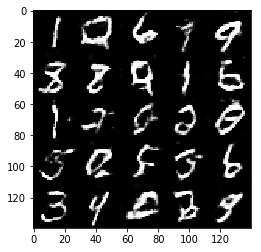

Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 2.1560
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 1.6866
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 0.6502... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 0.4293... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 0.4862... Generator Loss: 1.3411


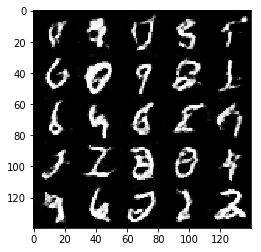

Epoch 2/2... Discriminator Loss: 0.3914... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 4.3464... Generator Loss: 5.8498
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 0.3403... Generator Loss: 1.8742
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.1736


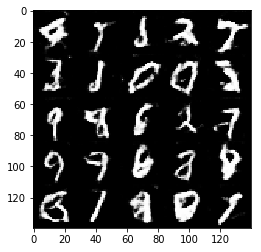

Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 1.4901
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.5625
Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 1.1768


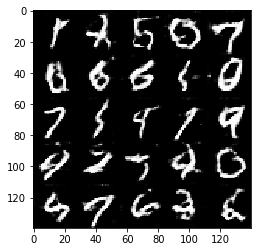

Epoch 2/2... Discriminator Loss: 0.4514... Generator Loss: 1.5488
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 1.5846
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.9501
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.1022
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 0.2601... Generator Loss: 2.0710
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.0974


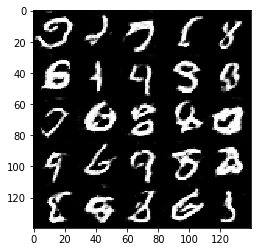

Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 2.0492
Epoch 2/2... Discriminator Loss: 0.5948... Generator Loss: 1.1741
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 1.8919
Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 1.3434
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 1.3707
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 1.8225


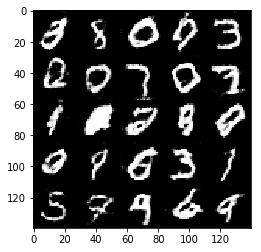

Epoch 2/2... Discriminator Loss: 1.4774... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.8764
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 1.8440
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 1.8974
Epoch 2/2... Discriminator Loss: 3.7298... Generator Loss: 0.0360


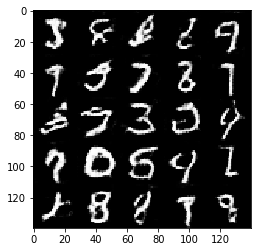

Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 1.5438
Epoch 2/2... Discriminator Loss: 0.4263... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.2127
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 1.7882
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 1.2004
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.5149


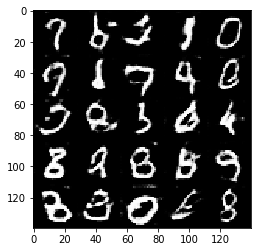

Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 1.6678
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.2904
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.6126
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 1.6869
Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 1.4306


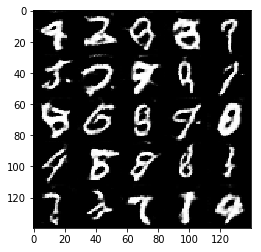

Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 1.6158
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 1.9674
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 1.0546
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 1.6850
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.1506
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.1020


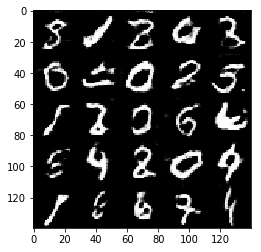

Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 2.1753
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.2476
Epoch 2/2... Discriminator Loss: 0.2671... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 1.9008
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.3584
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.4072
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.1111
Epoch 2/2... Discriminator Loss: 0.4394... Generator Loss: 1.6584


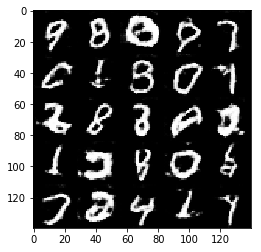

Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 0.9313
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 0.3665... Generator Loss: 1.6521
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.0203


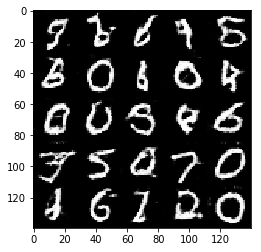

Epoch 2/2... Discriminator Loss: 0.4550... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 1.4546
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.2428
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.4960
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 1.2478
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.7467
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.0977
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 1.6948


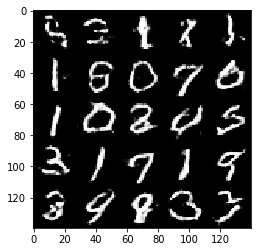

Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 0.7291... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 0.3945... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 0.3924... Generator Loss: 1.4724
Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 1.2328
Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 1.9312
Epoch 2/2... Discriminator Loss: 0.7199... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.2564


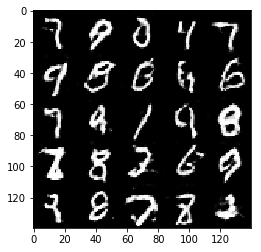

Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 1.3328
Epoch 2/2... Discriminator Loss: 0.5773... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 2.1960
Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 0.3962... Generator Loss: 1.8431
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.7430
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.5341
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 1.2885


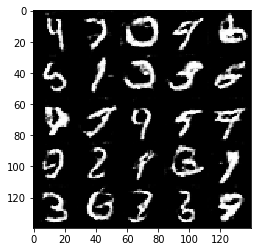

Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 1.4807
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 1.4947
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.1641
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 2.2158
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 1.5290... Generator Loss: 0.3530
Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 2.9762... Generator Loss: 0.0973


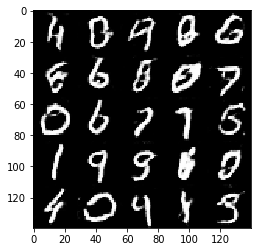

Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 2.6088
Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 1.8660
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 1.4264
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 1.6602


In [25]:
batch_size = 32
z_dim = 100 #50 (The images was gray, but are more less leigibe)
learning_rate =  0.0001 #0.001 #0.01 (Nothing leigible) 
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 0.3055... Generator Loss: 1.6977
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 2.0236
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 2.3132
Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 3.1166
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 2.5763
Epoch 1/1... Discriminator Loss: 0.2562... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 1.8003


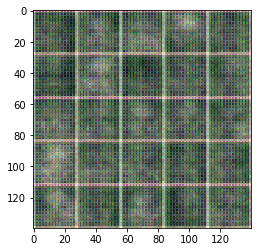

Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 2.4335
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 3.4521
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 3.1621
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.3294
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.9236


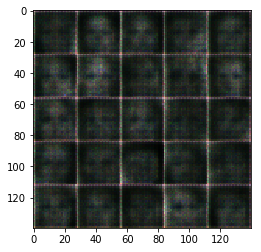

Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.0502


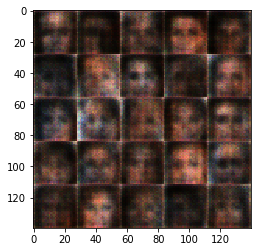

Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.1405
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.8455


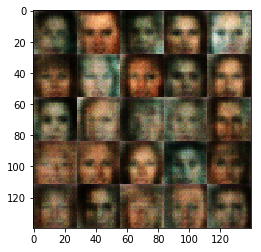

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 0.7563


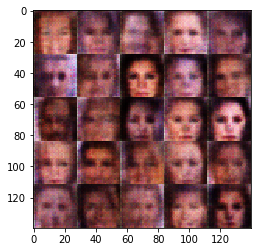

Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.8300
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.4131
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.2121
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.5931


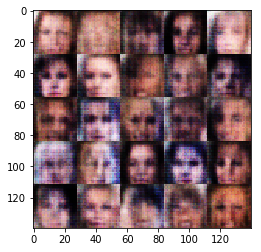

Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.1731
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 0.9120


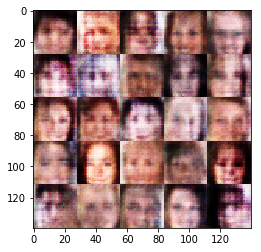

Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0043


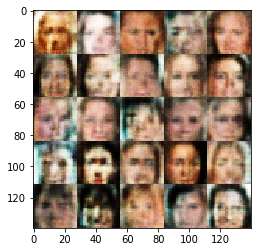

Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.7180


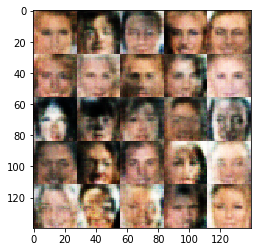

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 3.0159


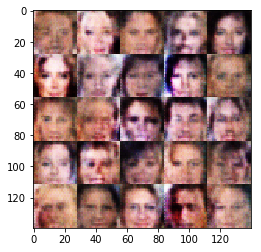

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.7092
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 2.3657
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.5987


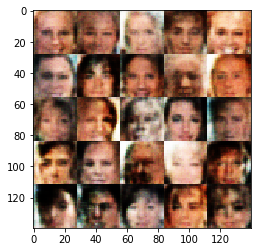

Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.2994
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.8100


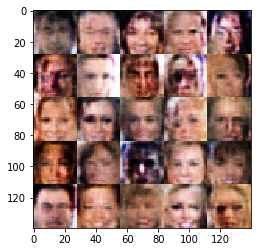

Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.5940
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.9454
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.7151


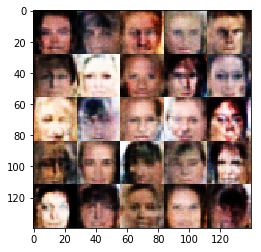

Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 2.0164
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 3.2440
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.1356


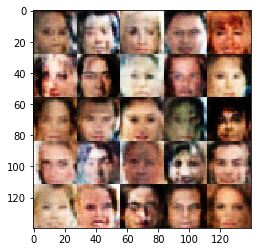

Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 1.4852


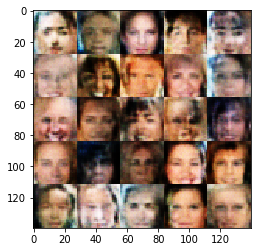

Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 2.1844
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 2.7124
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 4.4162


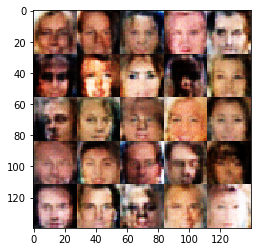

Epoch 1/1... Discriminator Loss: 0.3155... Generator Loss: 1.9882
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 0.1972... Generator Loss: 2.9860
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 3.0242
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 4.0001
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 4.7930


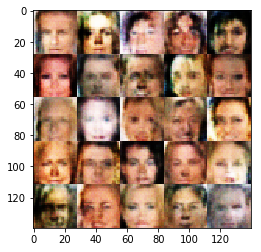

Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 3.5821
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 1.7673
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 3.2668
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 3.6054
Epoch 1/1... Discriminator Loss: 0.1675... Generator Loss: 4.3240
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 3.8453
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 3.1132


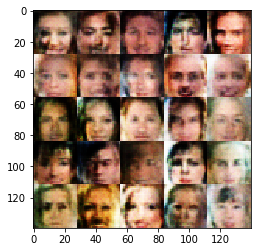

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 4.1170
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.5319
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.2833... Generator Loss: 3.4675
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 5.1856


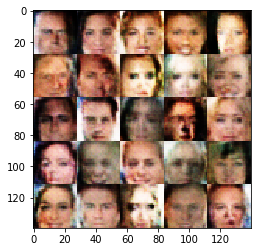

Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 2.3690
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 3.1945
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 2.4630
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 5.8035
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.4887
Epoch 1/1... Discriminator Loss: 0.1297... Generator Loss: 5.0333
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 1.9977
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 0.7540


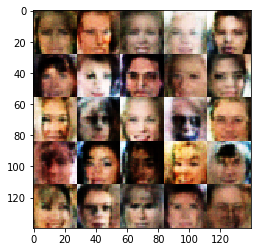

Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 0.2782... Generator Loss: 4.0922
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 2.2629
Epoch 1/1... Discriminator Loss: 0.2768... Generator Loss: 2.4976
Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 5.9361
Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.6762
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 3.1195
Epoch 1/1... Discriminator Loss: 0.3110... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 2.2222
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 6.2353


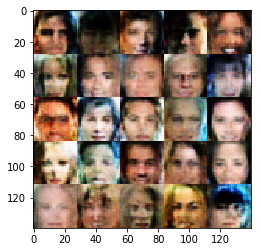

Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 8.4617
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.2974
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 5.2854
Epoch 1/1... Discriminator Loss: 0.2257... Generator Loss: 3.5844
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 3.3106
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 2.3527
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 3.2471
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.4453


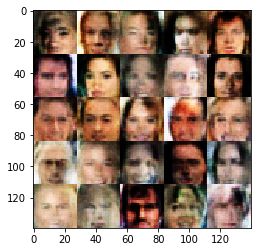

Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 2.4502
Epoch 1/1... Discriminator Loss: 0.1387... Generator Loss: 2.9573
Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 3.8299
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 4.0176
Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 3.5720
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 5.3426
Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 4.0550
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 5.6418
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 4.6980
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 5.9192


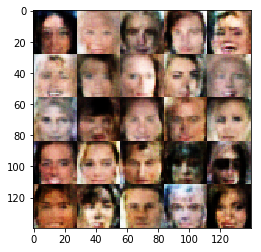

Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 0.2423... Generator Loss: 2.7671
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 2.4143
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 3.1159
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 2.8775
Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 1.9605
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 4.4387
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.6669
Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 5.7193
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 6.7561


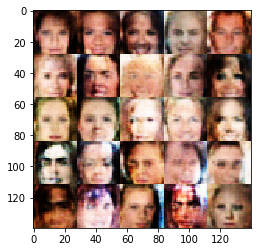

Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 5.2200
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 6.4663
Epoch 1/1... Discriminator Loss: 0.1676... Generator Loss: 4.0964
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 4.8993
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 3.8890
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 3.5113
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 2.3996
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 4.4897
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 6.3180


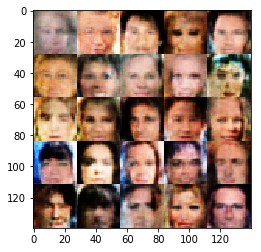

Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 3.5574
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 5.6132
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 2.8030
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.1359... Generator Loss: 4.0480
Epoch 1/1... Discriminator Loss: 0.0742... Generator Loss: 5.9894
Epoch 1/1... Discriminator Loss: 0.1685... Generator Loss: 3.2420
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 3.5905
Epoch 1/1... Discriminator Loss: 0.1130... Generator Loss: 3.1457
Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 2.6457


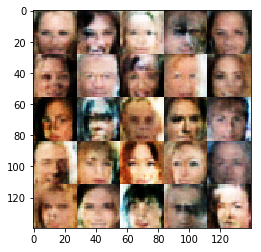

Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 6.6642
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 4.5110
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 3.1319
Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 0.0940... Generator Loss: 4.6072
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 2.8262
Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 2.3469
Epoch 1/1... Discriminator Loss: 0.1023... Generator Loss: 3.9422
Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 4.4284
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 6.0976


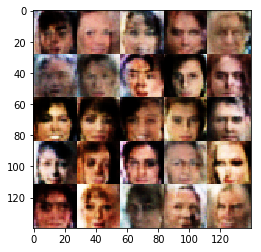

Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 4.6634
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.0529
Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 3.0269
Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.5018
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 5.4924
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 4.8039
Epoch 1/1... Discriminator Loss: 2.1661... Generator Loss: 4.9967
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 5.9381
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 6.1569
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 6.1187


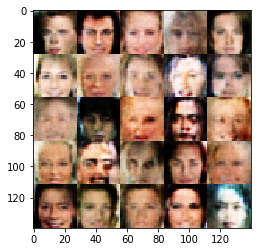

Epoch 1/1... Discriminator Loss: 0.1343... Generator Loss: 4.3819
Epoch 1/1... Discriminator Loss: 0.1336... Generator Loss: 3.5639
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.6416
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.7776
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 3.6835
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 1.8138
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 1.9265
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 4.3576
Epoch 1/1... Discriminator Loss: 0.0829... Generator Loss: 5.7085


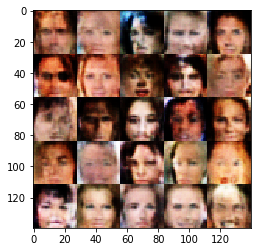

Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 6.3765
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 5.3582
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 5.0027
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 5.2628
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 6.1695
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 1.2061


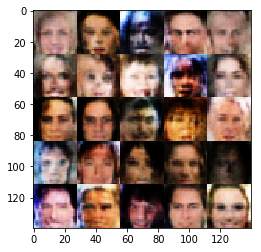

Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.1528
Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 4.6561
Epoch 1/1... Discriminator Loss: 0.1565... Generator Loss: 2.7326
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 4.3721
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 2.9342
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 2.3826
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.3304
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.2161
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 5.2717
Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 3.4674


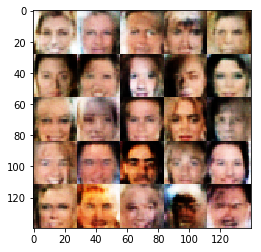

Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 4.0150
Epoch 1/1... Discriminator Loss: 0.0286... Generator Loss: 4.8931
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 4.2215
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 3.5952
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 4.2739
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.6103
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.2731
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 3.4381
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 5.6436
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 0.6928


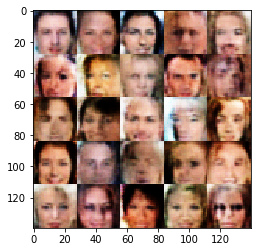

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.9596... Generator Loss: 0.1847
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 1.9631
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 7.5005
Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 5.0898
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 6.0944


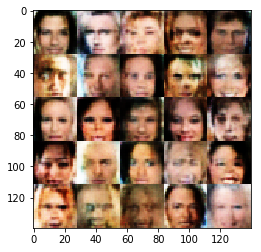

Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 2.2977
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 4.2847
Epoch 1/1... Discriminator Loss: 0.1689... Generator Loss: 4.5647
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 6.0679
Epoch 1/1... Discriminator Loss: 0.0742... Generator Loss: 4.0846
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 4.2075
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 2.2241
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.2378
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 6.1023
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 2.8555


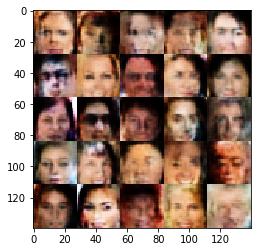

Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 2.7143
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 4.7117
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 3.9067
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 2.9081
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 2.0563
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 5.0618
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 4.4963
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.1928
Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 1.0044


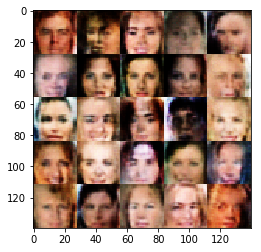

Epoch 1/1... Discriminator Loss: 1.7298... Generator Loss: 3.8074
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 1.7108
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 4.6194
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 3.3842
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 1.6619
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 2.8800
Epoch 1/1... Discriminator Loss: 0.1275... Generator Loss: 6.5239
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 3.7213


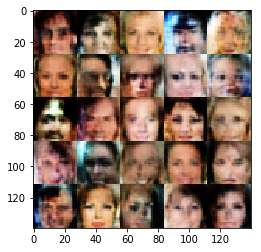

Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 5.1793
Epoch 1/1... Discriminator Loss: 0.0897... Generator Loss: 6.5980
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 7.2720
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 6.3273
Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 5.4088
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 3.3172
Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 2.0646
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.4890
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 5.3051
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 1.2070


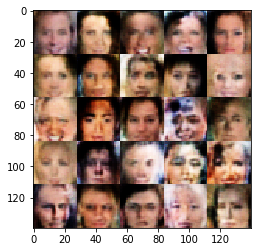

Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 5.9815
Epoch 1/1... Discriminator Loss: 0.0641... Generator Loss: 6.3970
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 4.6139
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 2.9458
Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 6.6428
Epoch 1/1... Discriminator Loss: 0.1130... Generator Loss: 3.2765
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 3.3549
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 3.5236
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 6.7582
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.4338


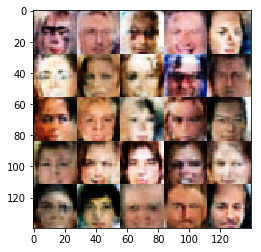

Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 6.0752
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 4.2965
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 6.8238
Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 2.7241
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 2.8060
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 6.7870
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 5.7309
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 1.6959
Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 6.2559
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 7.5854


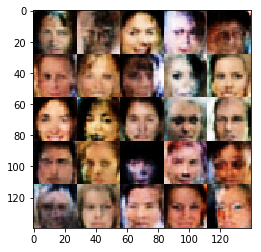

Epoch 1/1... Discriminator Loss: 0.2268... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 6.3762
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 8.4161
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 7.5169
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 3.6764
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 2.6855
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 5.1501
Epoch 1/1... Discriminator Loss: 0.2063... Generator Loss: 2.1037
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 2.3229
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 2.6042


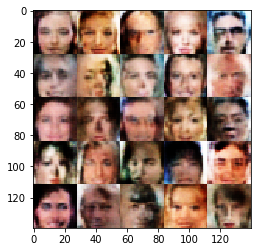

Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 6.1666
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 6.9180
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 5.0270
Epoch 1/1... Discriminator Loss: 3.2490... Generator Loss: 5.5814
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 5.6337
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 5.1843
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 4.7502
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.3596


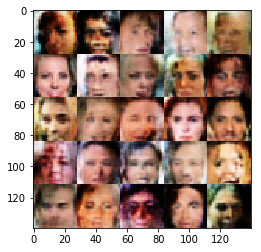

Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 3.2087
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 4.2570
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 8.3203
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 5.2093
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 4.9376
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 7.2731
Epoch 1/1... Discriminator Loss: 0.0433... Generator Loss: 4.1967
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 6.6138
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 3.2295
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 3.2775


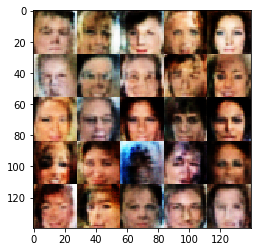

Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 4.8321
Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 7.6963
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 6.5364
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.7641
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 5.4858
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 7.6339
Epoch 1/1... Discriminator Loss: 0.0311... Generator Loss: 4.5802
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 3.5760
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 3.1017
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 7.0410


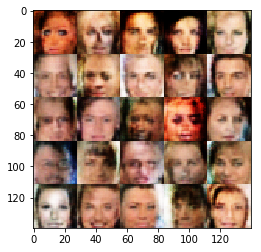

Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 1.8464
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 3.6112
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 2.5847
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 3.9139
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 3.7942
Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 4.0568
Epoch 1/1... Discriminator Loss: 0.2926... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 0.0567... Generator Loss: 3.5478
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.4806
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.8630


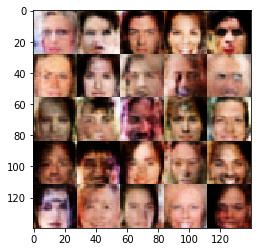

Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 2.0458
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 3.8750
Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 2.6817
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.9751
Epoch 1/1... Discriminator Loss: 0.1354... Generator Loss: 2.7668
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 5.1564
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 5.3464
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 4.8604
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 4.8942


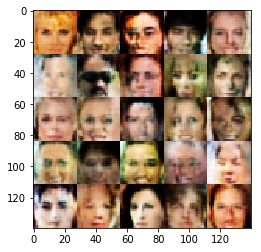

Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 6.1542
Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 3.0872
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 2.5852
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 5.8292
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 3.8252
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 5.6704
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 7.3427
Epoch 1/1... Discriminator Loss: 0.1314... Generator Loss: 2.7535
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 1.4936


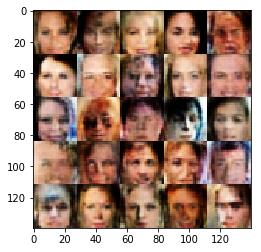

Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 1.5135
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 9.0706
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 4.3470
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 3.4671
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 5.1205
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 4.2069
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 6.3170
Epoch 1/1... Discriminator Loss: 0.0212... Generator Loss: 4.8130
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 4.4863
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.6794


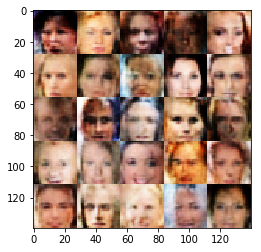

Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 2.7346
Epoch 1/1... Discriminator Loss: 0.0534... Generator Loss: 3.2412
Epoch 1/1... Discriminator Loss: 0.0837... Generator Loss: 3.9220
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 5.9457
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 7.5189
Epoch 1/1... Discriminator Loss: 5.5828... Generator Loss: 0.0134
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 0.2173... Generator Loss: 4.0265
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 1.5628


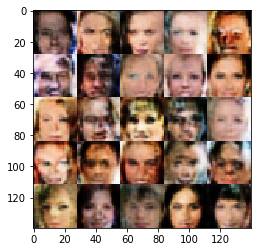

Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 4.4261
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 5.6641
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 2.8728
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 5.5997
Epoch 1/1... Discriminator Loss: 2.7454... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 5.8422
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 4.2097
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 5.6062
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 2.2761


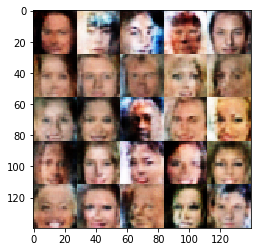

Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 5.2147
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 2.8342
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 0.2208... Generator Loss: 2.1700
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 8.7786
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 4.3511
Epoch 1/1... Discriminator Loss: 0.2278... Generator Loss: 2.9405
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 7.8766
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 2.4146


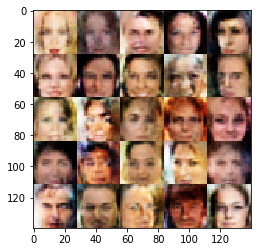

Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 3.7665
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 2.2660
Epoch 1/1... Discriminator Loss: 0.3144... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 3.0488
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 2.2902
Epoch 1/1... Discriminator Loss: 0.2798... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 0.1315... Generator Loss: 2.9299
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 3.3302
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.2061... Generator Loss: 5.6990


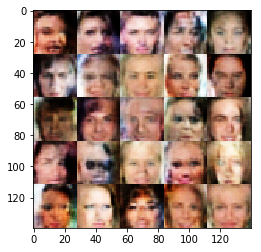

Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 3.7935
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 4.9409
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 8.1378
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 4.2416
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 7.6122
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 4.9632
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 4.6498
Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 7.8181
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 5.5705
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 4.0006


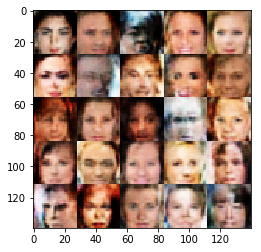

Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 6.1971
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 2.6272
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 7.2310
Epoch 1/1... Discriminator Loss: 2.7002... Generator Loss: 3.1062
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 2.0601... Generator Loss: 0.2264
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 0.1396... Generator Loss: 5.6277
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 4.3456
Epoch 1/1... Discriminator Loss: 0.1297... Generator Loss: 4.1615


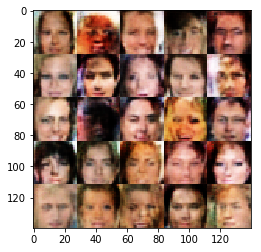

Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 1.8424
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 5.0100
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 3.2382
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 3.2331
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 2.0702
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 4.7064
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 4.9428
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 2.7132
Epoch 1/1... Discriminator Loss: 0.0958... Generator Loss: 3.5213


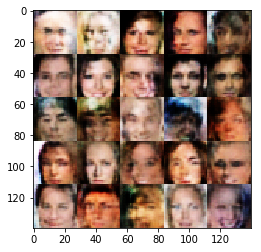

Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.3917
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 4.8086
Epoch 1/1... Discriminator Loss: 0.3090... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 8.6489
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 7.7613
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 3.9515
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 3.8024
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.1296
Epoch 1/1... Discriminator Loss: 0.1037... Generator Loss: 2.9049
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 6.5880


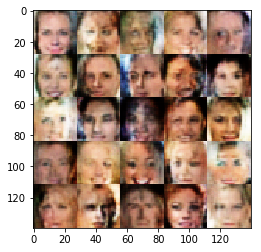

Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 5.5353
Epoch 1/1... Discriminator Loss: 0.0477... Generator Loss: 4.6331
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 7.9501
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 5.2945
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 1.9103
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 3.8419
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.8207
Epoch 1/1... Discriminator Loss: 0.3140... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 0.0654... Generator Loss: 3.9181


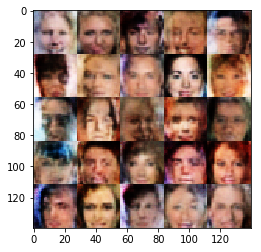

Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 3.5390
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 6.9085
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 3.0044
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 5.8994
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.1947... Generator Loss: 2.0696
Epoch 1/1... Discriminator Loss: 0.1491... Generator Loss: 2.2361
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 6.7671
Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 4.7415
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 5.5233


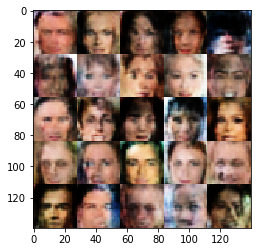

Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 5.9203
Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 4.1838
Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 2.8773
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 3.4013
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.5130
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 4.2054
Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 5.6080
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 6.8535


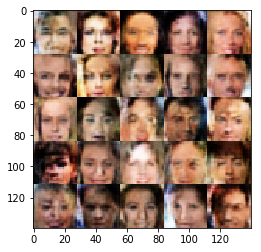

Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 6.4560
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 2.6330
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 4.2300
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 3.2661
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 6.7311
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 3.7896
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 3.9485
Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 4.0943


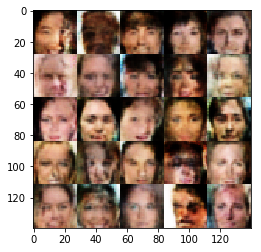

Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 2.7556
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 10.3139
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 3.0141
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 9.6066
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.0679
Epoch 1/1... Discriminator Loss: 0.0372... Generator Loss: 3.9524
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 3.5262
Epoch 1/1... Discriminator Loss: 0.3019... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 3.4601


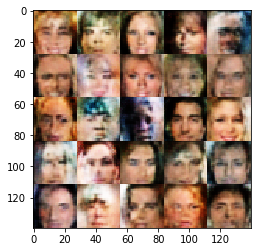

Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 5.4675
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 4.2314
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 5.8669
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 5.6656
Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 7.0645
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 5.9234
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.3384


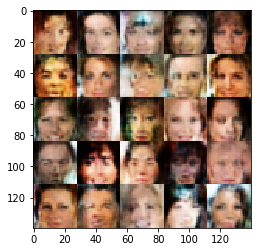

Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 2.2903
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.1486... Generator Loss: 5.8109
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 4.8146
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 6.2373


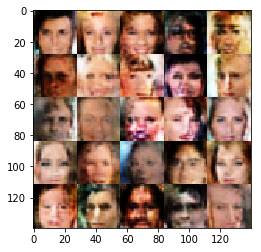

Epoch 1/1... Discriminator Loss: 0.0829... Generator Loss: 3.0259
Epoch 1/1... Discriminator Loss: 0.1169... Generator Loss: 3.6705
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 2.4342
Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.2231
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 3.0761
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 2.7496
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 3.9875
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 5.0279


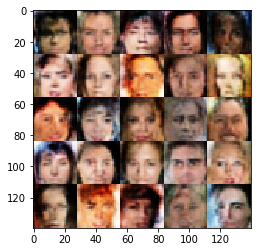

Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 1.7538
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 0.2229... Generator Loss: 3.2555


In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001 #0.0005 #0.001 (Some faces were darker than the faces of the horror movie characters)
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.